In [61]:
import numpy as np
import pandas as pd
#from keras.preprocessing.image import ImageDataGenerator
import os
import random
import cv2
import random
import matplotlib.pyplot as plt
import imutils
import tensorflow as tf
from sklearn.preprocessing import LabelBinarizer

#from google.colab.patches import cv2_imshow

In [62]:
# Initialize a LabelBinarizer object
LB = LabelBinarizer()

  # Fit LabelBinarizer to data
labels = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S',
              'T','U','V','W','X','Y','Z','a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 
              'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 
              'y', 'z']  # Replace with your actual class labels

LB.fit(labels)

LabelBinarizer()

### sort_contours function
##### This function sorts contours based on their positions within an image. It can sort contours either from left to right, right to left, top to bottom, or bottom to top, depending on the specified method. It computes bounding boxes for each contour, sorts both contours and their bounding boxes according to the specified dimension (either x or y coordinate) and direction (ascending or descending), and returns the sorted contours along with their bounding boxes.

In [63]:
def sort_contours(cnts, method="left-to-right"):
    # Initialize the reverse flag to False
    reverse = False
    # Initialize the dimension index to 0 (x coordinate)
    i = 0

    # If sorting in right-to-left or bottom-to-top, set reverse to True
    if method in ["right-to-left", "bottom-to-top"]:
        reverse = True

    # If sorting by vertical position (top-to-bottom or bottom-to-top), use the y coordinate
    if method in ["top-to-bottom", "bottom-to-top"]:
        i = 1

    # Compute the bounding boxes for each contour
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]

    # Sort the contours and bounding boxes by the specified dimension and direction
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
                                        key=lambda b: b[1][i], reverse=reverse))

    # Return the sorted contours and their bounding boxes
    return (cnts, boundingBoxes)


### get_letters function
##### The function detects and recognizes letters in an image by converting it to grayscale, creating a binary image, identifying contours, extracting the region of interest (ROI), applying thresholding, resizing, and normalizing pixel values. It then uses a trained model to predict the letter, appending the recognized letters to a list, and drawing bounding boxes around the detected letters.

In [64]:

def get_letters(img):
    """
    Function to detect and recognize letters in an image.
    
    Parameters:
    img (str): Path to the input image file.
    
    Returns:
    letters (list): List containing the recognized letters.
    image (numpy.ndarray): Image with bounding boxes drawn around detected letters.
    """
    letters = []  # List to store information about detected letters
    image = cv2.imread(img)  # Read image
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Convert image to grayscale
    ret, thresh1 = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)  # Apply thresholding to create a binary image
    dilated = cv2.dilate(thresh1, None, iterations=2)  # Dilate the binary image

    cnts = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)  # Find contours in the binary image
    cnts = imutils.grab_contours(cnts)
    cnts = sort_contours(cnts, method="left-to-right")[0]  # Sort contours from left to right

    # Load the trained model
    model_path = "handwritten_model.keras"
    model = tf.keras.models.load_model(model_path)

    # Loop over the contours
    for c in cnts:
        if cv2.contourArea(c) > 10:
            (x, y, w, h) = cv2.boundingRect(c)
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Draw bounding box around detected letter
        roi = gray[y:y + h, x:x + w]  # Extract region of interest (ROI) containing the letter
        thresh = cv2.threshold(roi, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]  # Apply thresholding to the ROI
        thresh = cv2.resize(thresh, (32, 32), interpolation=cv2.INTER_CUBIC)  # Resize the ROI to 32x32 pixels
        thresh = thresh.astype("float32") / 255.0  # Normalize the pixel values
        thresh = np.expand_dims(thresh, axis=-1)  # Add an extra dimension to represent batch size
        thresh = thresh.reshape(1, 32, 32, 1)  # Reshape the array to match model input shape
        ypred = model.predict(thresh)  # Predict the letter using the model
        ypred = LB.inverse_transform(ypred)  # Inverse transform the predicted label
        [p] = ypred
        letters.append(p)  # Append the recognized letter to the list
    
    return letters, image


In [65]:
def get_word(letter):
    word = "".join(letter)
    return word

In [66]:
handwritting_test_dir = "../handwritting_dataset/Test/"
image_path = os.path.join(handwritting_test_dir, 'TEST_9716.jpg')
image_path

'../handwritting_dataset/Test/TEST_9716.jpg'

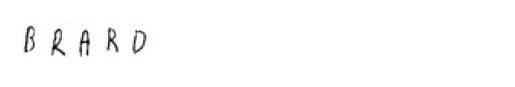

In [67]:
img = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
# Convert the image from BGR to RGB (OpenCV loads images in BGR format by default)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Display the image
plt.imshow(img_rgb)
plt.axis('off')  # Turn off axis labels
plt.show()

### Test the model
#### Pass the handwritting images to test the model for character classification

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step

Handritting Recognition Model

The word written on the image is : BRARD


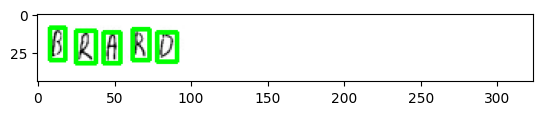

In [68]:
image_path = os.path.join(handwritting_test_dir, 'TEST_9716.jpg')
letter,image = get_letters(image_path)

word = get_word(letter)
print('\nHandritting Recognition Model\n')
plt.imshow(image)
print(f"The word written on the image is : {word}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

Handritting Recognition Model

The word written on the image is : ROSE


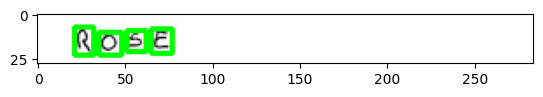

In [69]:
image_path = os.path.join(handwritting_test_dir, 'TEST_9599.jpg')
letter,image = get_letters(image_path)

word = get_word(letter)
print('\nHandritting Recognition Model\n')
plt.imshow(image)
print(f"The word written on the image is : {word}")